In [1]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainerReinforce, ChunkTrainerRelReinforce

from dpp_nets.utils.language import EvalSet

In [33]:
# Load saved checkpoint
model = 'shortwords1reg0.1reg_mean30.0lr0.0001reinforce_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/reinforce/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)

In [34]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [35]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1
ALPHA_ITER = 1

if model['mode'] == 'sents':
    trainer = ChunkTrainerReinforce(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM, ALPHA_ITER)
else:
    trainer = ChunkTrainerRelReinforce(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM, ALPHA_ITER)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [36]:
trainer.kernel_net.layer1.weight

Parameter containing:
-8.5797e-02  9.6903e-02  7.3010e-02  ...   3.8312e-02 -4.3236e-02 -3.7457e-02
 2.0090e-02  1.9809e-02 -2.3330e-02  ...   8.3203e-02 -9.3956e-03 -6.2876e-02
-9.6869e-03 -4.5742e-02 -8.1854e-02  ...   6.1070e-03 -3.0414e-02  4.9252e-02
                ...                   ⋱                   ...                
-5.1710e-02  2.8279e-04  1.9276e-02  ...  -3.4641e-02  4.0673e-02 -2.0192e-03
-4.9892e-02 -2.3355e-03 -8.6964e-04  ...   5.9288e-02  4.3253e-02 -7.0590e-02
 4.0152e-02  1.4422e-01  2.6059e-02  ...   5.4422e-02 -2.7372e-02 -4.3750e-02
[torch.FloatTensor of size 500x400]

In [37]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 0.02539 | Pred Loss: 0.02469 | Reg Loss: 0.00070
Epoch: 1 | Loss: 0.02007 | Pred Loss: 0.01990 | Reg Loss: 0.00017
Epoch: 2 | Loss: 0.01724 | Pred Loss: 0.01710 | Reg Loss: 0.00014
Epoch: 3 | Loss: 0.01496 | Pred Loss: 0.01482 | Reg Loss: 0.00014
Epoch: 4 | Loss: 0.01290 | Pred Loss: 0.01276 | Reg Loss: 0.00014
Epoch: 5 | Loss: 0.01131 | Pred Loss: 0.01116 | Reg Loss: 0.00015
Epoch: 6 | Loss: 0.05174 | Pred Loss: 0.05041 | Reg Loss: 0.00133
Epoch: 7 | Loss: 0.05513 | Pred Loss: 0.05329 | Reg Loss: 0.00184
Epoch: 8 | Loss: 0.03385 | Pred Loss: 0.03179 | Reg Loss: 0.00206


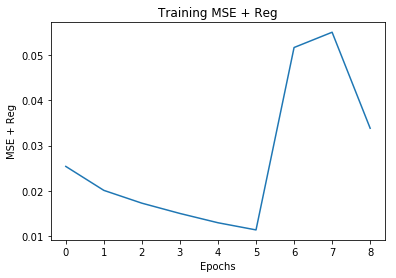

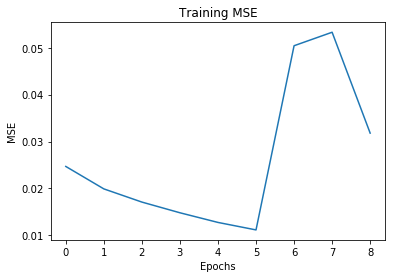

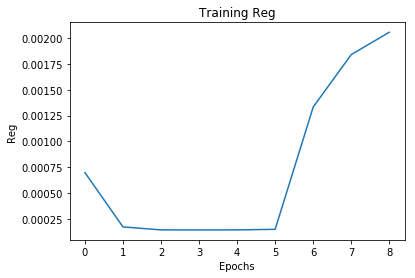

In [38]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [39]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.02214 | Pred Loss: 0.02193 | Reg Loss: 0.00021
Epoch: 1 | Loss: 0.01975 | Pred Loss: 0.01961 | Reg Loss: 0.00014
Epoch: 2 | Loss: 0.01863 | Pred Loss: 0.01850 | Reg Loss: 0.00013
Epoch: 3 | Loss: 0.01816 | Pred Loss: 0.01802 | Reg Loss: 0.00014
Epoch: 4 | Loss: 0.01808 | Pred Loss: 0.01794 | Reg Loss: 0.00014
Epoch: 5 | Loss: 0.01809 | Pred Loss: 0.01793 | Reg Loss: 0.00015
Epoch: 6 | Loss: 0.06479 | Pred Loss: 0.06289 | Reg Loss: 0.00190
Epoch: 7 | Loss: 0.04099 | Pred Loss: 0.03888 | Reg Loss: 0.00212
Epoch: 8 | Loss: 0.03389 | Pred Loss: 0.03176 | Reg Loss: 0.00214


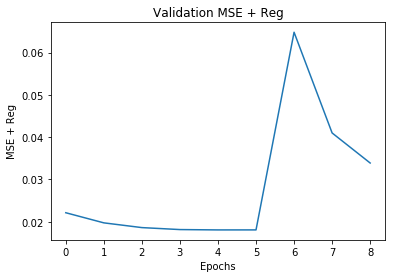

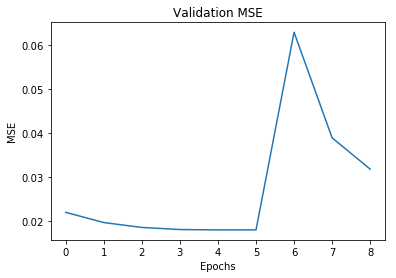

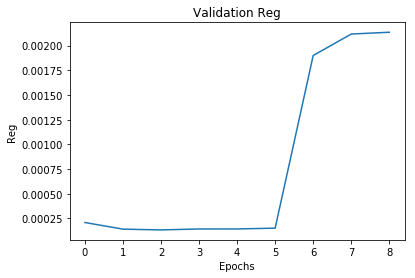

In [40]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [41]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.02055 | Pred Loss: 0.01881 | Reg Loss: 0.00174
Test Set: | Precision: 0.54030 | Extract: 0.06637


In [28]:
# Random Samples
evalset.sample(trainer, model['mode'])

index is: 468
('weak',) set() [('weak',)]
('beers',) set() [('beers',)]
('substance',) set() [('substance',)]
('forgettable',) set() [('forgettable',)]
('sour',) {'1'} [('sour',)]
('exciting',) set() [('exciting',)]
('stout',) {'0'} [('stout',)]
('saying',) set() [('saying',)]
('quickly',) {'0'} [('quickly',)]
('likewise',) {'0'} [('likewise',)]
Precision is: 0.4
Extraction Percentage is: 0.08064516129032258
[(Let me start by saying it's exciting to see beers from Mexico which have color and substance and flavor., set()), (In fact this is the first craft beer I've ever had from Mexico.		, set()), (Poured a meager 1" head which quickly dissipated to lace., {'0'}), (Dark in color almost like a stout and flavor likewise was similar to a mild stout but with a lighter body., {'0'}), (Smell and taste both had touch of sour almost like a drop of Flemish sour.		, {'1'}), (Anyway, a big step up from forgettable weak Mexican beers, but nowhere close to the craft beers from the States or from Eur

RuntimeError: input and target have different number of elements: input[100 x 3] has 300 elements, while target[3] has 3 elements at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/THNN/generic/MSECriterion.c:12

In [11]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'], 397)

index is: 397
0 0.549766924786 ('luscious',)
1 0.519408797876 ('balanced',)
2 0.50610014369 ('alcohol',)
3 0.49311295878 ('pear',)
4 0.461492428317 ('aroma',)
5 0.394499445425 ('bitter',)
6 0.342531732584 ('minimal',)
7 0.323079637132 ('initial',)
8 0.30356740096 ('rather',)
9 0.303334538764 ('also',)
10 0.303199056182 ('orangy',)
11 0.28635213081 ('modest',)
12 0.279423096371 ('maple',)
13 0.262360241968 ('back',)
14 0.239793818183 ('offset',)
15 0.231872278559 ('took',)
16 0.226868038352 ('--',)
17 0.217652021045 ('medium',)
18 0.212753540135 ("'s",)
19 0.205490446092 ('potent',)
20 0.204760849527 ('quickly',)
21 0.188842681776 ('think',)
22 0.178785820959 ('poured',)
23 0.177608366315 ('clear',)
24 0.173306350039 ('dark',)
25 0.162810314981 ('fades',)
26 0.161427160731 ('2002',)
27 0.161040237487 ('cherry',)
28 0.16007593745 ('tart',)
29 0.159982566604 ('2003',)
30 0.158804968384 ('well',)
31 0.149028697022 ('malts',)
32 0.146853994495 ('expected',)
33 0.14161987744 ('spices',)
34 0

In [22]:
evalset.computeMUEPredLoss(trainer, model['mode'],100)

(0.012876863448606085, 0.012892113315031472)

In [13]:
evalset.computeMAPPredLoss(trainer, model['mode'])

(0.014311427982221337, 0.0831022014637619)

In [14]:
from torch.autograd import Variable
review = evalset.vocab.returnEmbds(evalset.words[0].clean.keys()).unsqueeze(0)
target = Variable(torch.stack([evalset.targets[0] for _ in range(100)]))

In [15]:
trainer.alpha_iter = 100
trainer.sampler.alpha_iter = 100
trainer(review, target)

Variable containing:
1.00000e-02 *
  2.3543
[torch.FloatTensor of size 1]